## For 1 part:

In [1]:
from Test_com_2 import compute_trajectories
from MAGIK_model import Classifier_model
from Build_graph import Graph_Generator
import numpy as np
from deeplay import BinaryClassifier, Adam
import torch
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device("cpu")
checkpt_pth = "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/model_(Consec(mean), num=50, new_D)(500).pt"
new_model = Classifier_model()
classifier = BinaryClassifier(model=new_model, optimizer=Adam(lr=1e-3))
classifier = classifier.create()
classifier.model.load_state_dict(torch.load(checkpt_pth, weights_only=True))
classifier.model.to(device) 
classifier.eval()

graph_Generator = Graph_Generator(
    connectivity_radius= 30, frame_test=(0,30)
        )
test_graph = graph_Generator(particle_feature_pth= "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_fea(mean_intens)(orient).csv")

pred = classifier(test_graph.to(device))
#print(pred)
#predictions = pred.detach().cpu().numpy() > 0.5
predictions = pred.detach().numpy()
predictions = np.where(predictions < 0.5, 0.0, predictions)
post_processor = compute_trajectories()
_, prune_edges = post_processor(test_graph, predictions.squeeze())
frames = test_graph.frames.cpu().numpy()

/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Prune Edges (Batched): 100%|██████████| 53/53 [00:01<00:00, 34.74it/s]


# Check if i>j in (i,j) for prune_edges:

In [132]:
for i,j in prune_edges:
    if i==j:
        print(i)

## use recurssion to find path of all particle:

In [2]:
max_value = max(max(tup) for tup in prune_edges)
id_mask = np.zeros(max_value+1, dtype=bool)

def recurr(prune_edges, num, path, id_mask):
    
    found = False
    for i, j in prune_edges:
        if i == num:
            path.append(i)
            new_num = j
            id_mask[i] = True
            id_mask[j] = True
            found = True
            return recurr(prune_edges, new_num, path, id_mask)
    if not found:
        if id_mask[num]:
            path.append(num)
        id_mask[num] = True
        return path, id_mask

path_ls = []
for idx in range(max_value+1):
    if not id_mask[idx]: 
        path, id_mask = recurr(prune_edges, idx, [], id_mask.copy())
        if len(path) > 0:
            path_ls.append(path)
print(len(path_ls))
print(path_ls[18])

364
[18, 190]


## print traj generated

In [7]:
traj_coord = []
with tqdm(total=len(path_ls), desc="Gen Coord") as pbar:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for traj in path_ls:
        if len(traj) > 2: 
            frames = test_graph.frames[traj].to(device)
            traj_tensor = torch.tensor(traj, device=device, dtype=torch.int64)
            coordinates = test_graph.x.to(device)[traj_tensor]
            coordinates[:, 0] = coordinates[:, 0]*1314
            coordinates[:, 1] = coordinates[:, 1]*1054
            traj_coord.append((frames.cpu().numpy(), coordinates.cpu().numpy()))
            pbar.update(1)

torch.cuda.empty_cache()

Gen Coord:  88%|████████▊ | 319/364 [00:00<00:00, 6320.51it/s]


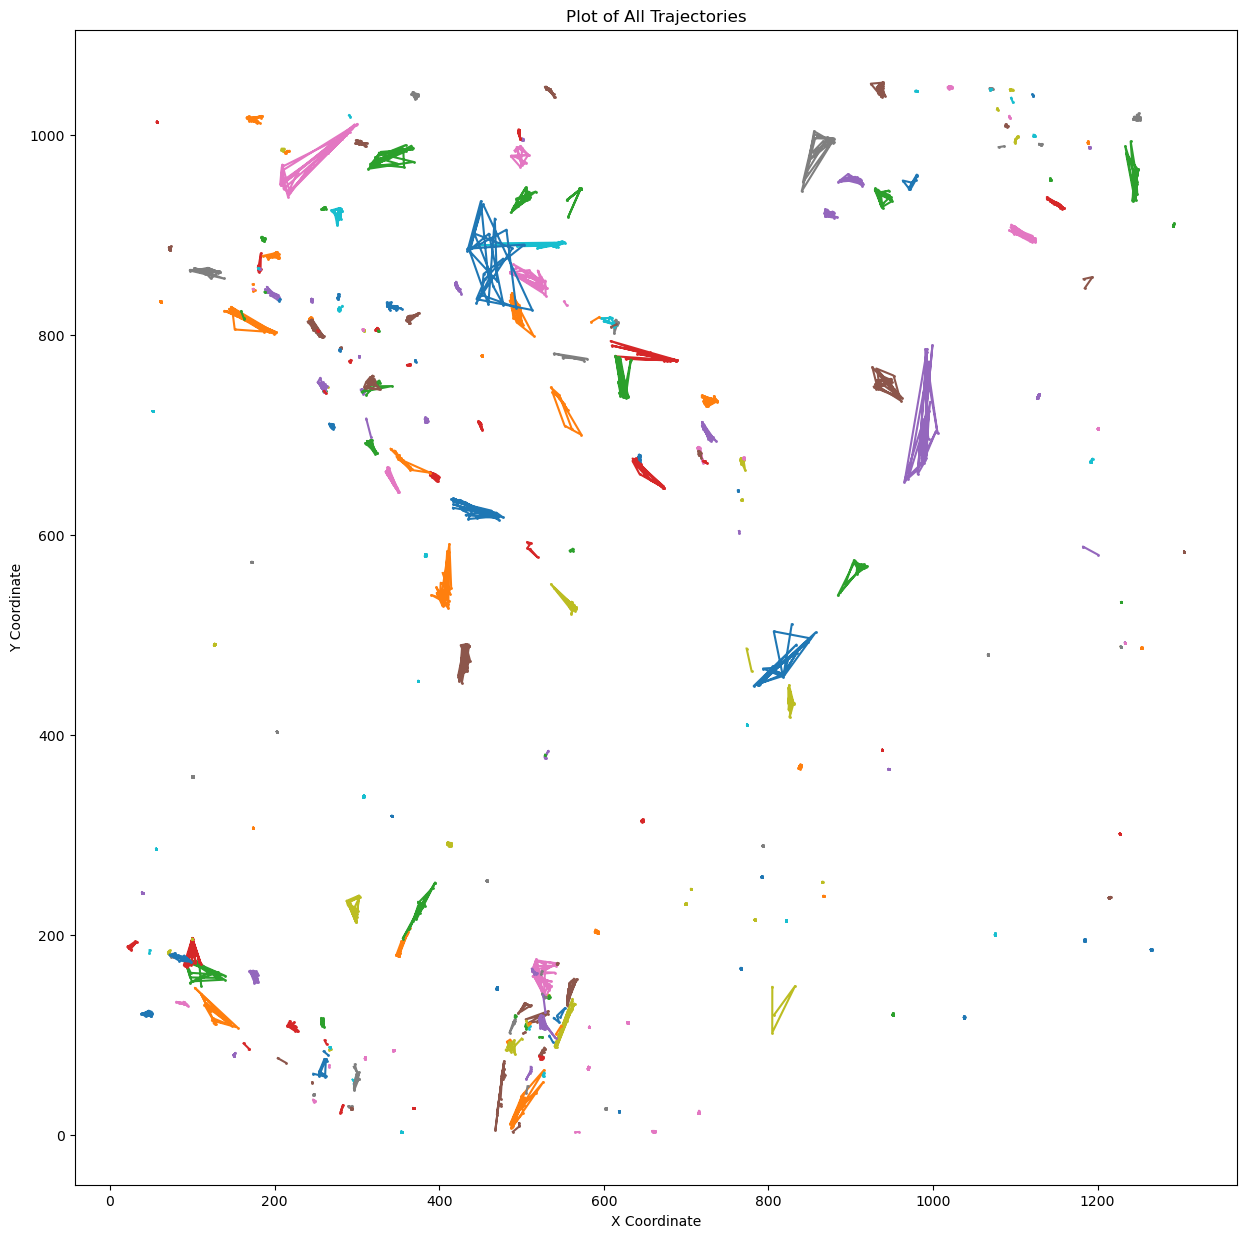

In [15]:
import matplotlib.pyplot as plt

# Create a new figure for the plot
plt.figure(figsize=(15, 15))

for sorted_frames, coordinates in traj_coord:
    plt.plot(coordinates[:, 0], coordinates[:, 1], marker='o', markersize=1)

# Set labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Plot of All Trajectories")

# Show the plot
plt.show()

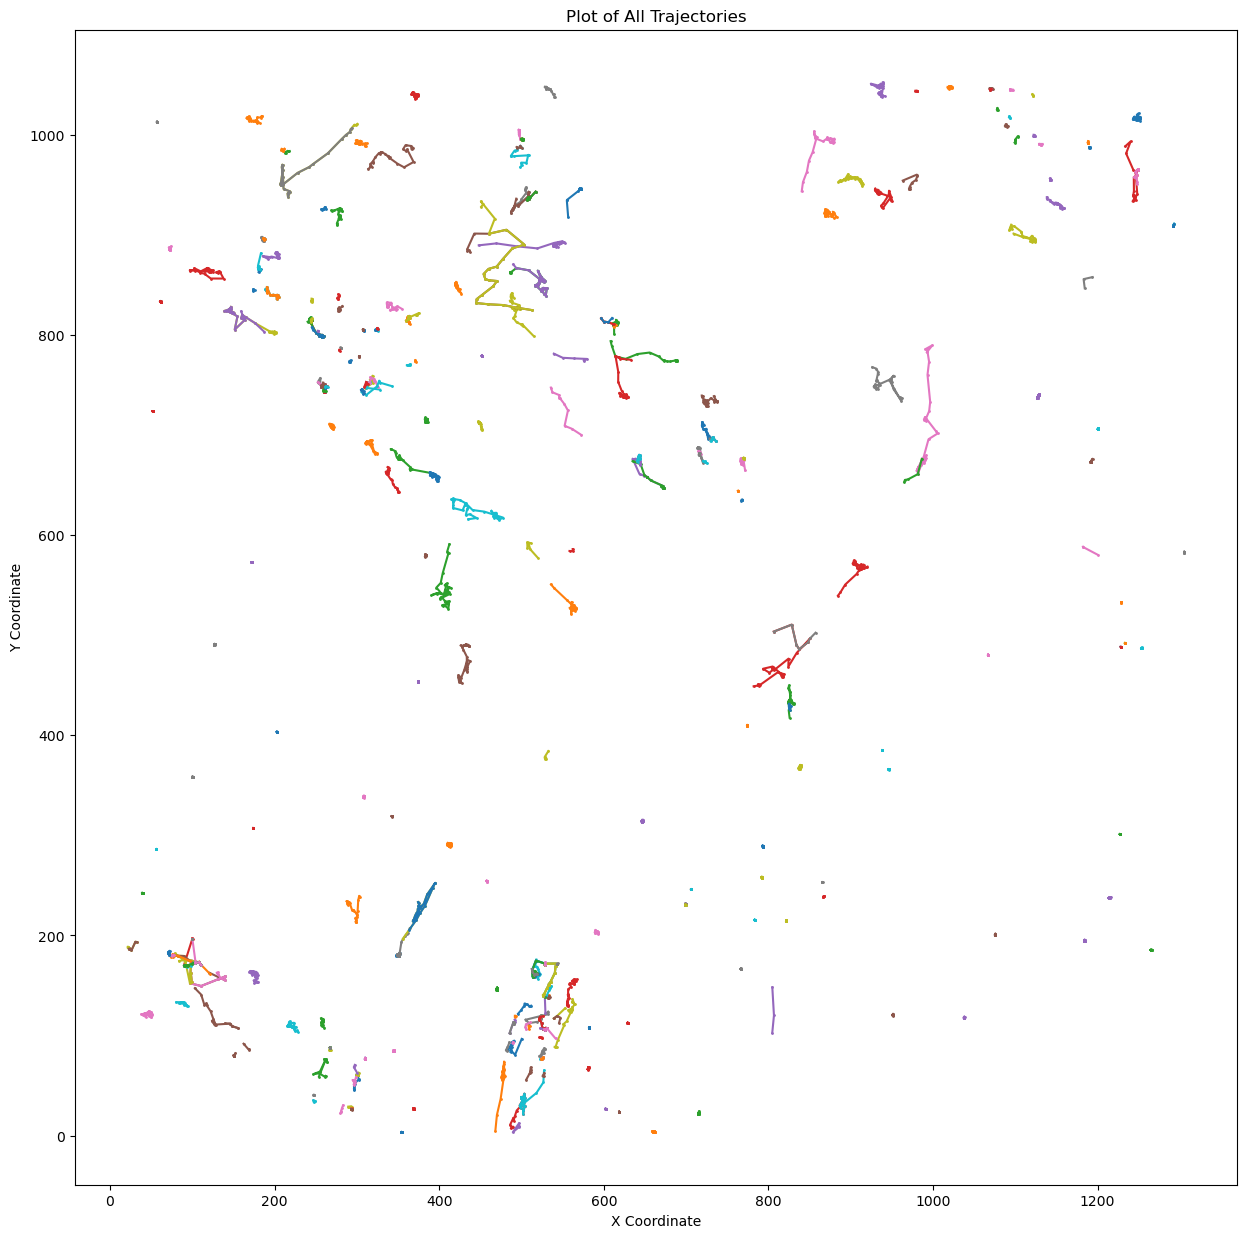

In [8]:
import matplotlib.pyplot as plt

# Create a new figure for the plot
plt.figure(figsize=(15, 15))

for sorted_frames, coordinates in traj_coord:
    plt.plot(coordinates[:, 0], coordinates[:, 1], marker='o', markersize=1)

# Set labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Plot of All Trajectories")

# Show the plot
plt.show()

# CHeck combine

### before combine

In [6]:
## before combine:
from Test_com_2 import compute_trajectories
from MAGIK_model import Classifier_model
from Build_graph import Graph_Generator
import numpy as np
from deeplay import BinaryClassifier, Adam
import torch
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device("cpu")
checkpt_pth = "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/model_(Consec(mean), num=50, new_D)(500).pt"
new_model = Classifier_model()
classifier = BinaryClassifier(model=new_model, optimizer=Adam(lr=1e-3))
classifier = classifier.create()
classifier.model.load_state_dict(torch.load(checkpt_pth, weights_only=True))
classifier.model.to(device) 
classifier.eval()

graph_Generator = Graph_Generator(
    connectivity_radius= 30, frame_test=(0,40)
        )
test_graph = graph_Generator(particle_feature_pth= "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_fea(mean_intens)(orient).csv")

pred = classifier(test_graph.to(device))
predictions = pred.detach().numpy()
predictions = np.where(predictions < 0.5, 0.0, predictions)

post_processor = compute_trajectories()
trajectories = post_processor(test_graph, predictions.squeeze())
filter_traj_total= [traj for traj in trajectories if len(traj) > 2]

traj_coord = []
with tqdm(total=len(filter_traj_total), desc="Gen Coord") as pbar:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for traj in filter_traj_total:
            frames = test_graph.frames[traj].to(device)
            traj_tensor = torch.tensor(traj, device=device, dtype=torch.int64)
            coordinates = test_graph.x.to(device)[traj_tensor]
            coordinates[:, 0] = coordinates[:, 0]*1314
            coordinates[:, 1] = coordinates[:, 1]*1054
            traj_coord.append((frames.cpu().numpy(), coordinates.cpu().numpy()))
            pbar.update(1)
torch.cuda.empty_cache()

Gen Coord: 100%|██████████| 295/295 [00:00<00:00, 10073.68it/s]


### make combination

Gen Coord: 100%|██████████| 295/295 [00:00<00:00, 8124.23it/s]


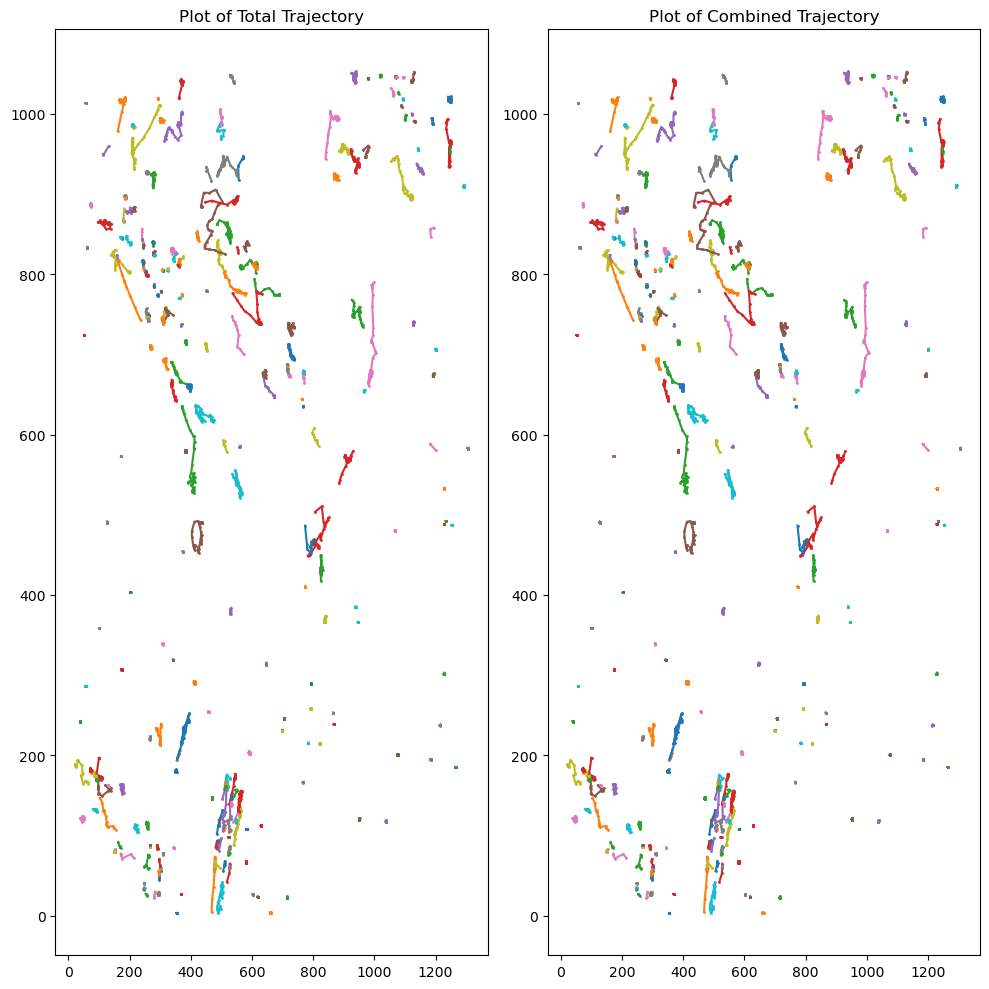

In [8]:
from Test_com_2 import process_traj, compute_trajectories
device = torch.device("cpu")
checkpt_pth = "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/model_(Consec(mean), num=50, new_D)(500).pt"
new_model = Classifier_model()
classifier = BinaryClassifier(model=new_model, optimizer=Adam(lr=1e-3))
classifier = classifier.create()
classifier.model.load_state_dict(torch.load(checkpt_pth, weights_only=True))
classifier.model.to(device) 
classifier.eval()

graph_Generator = Graph_Generator(
    connectivity_radius= 30, frame_test=(0,20)
        )
test_graph_1 = graph_Generator(particle_feature_pth= "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_fea(mean_intens)(orient).csv")

pred = classifier(test_graph_1.to(device))
predictions = pred.detach().numpy()
predictions_1 = np.where(predictions < 0.5, 0.0, predictions)

graph_Generator = Graph_Generator(
    connectivity_radius= 30, frame_test=(16,40)
        )
test_graph_2 = graph_Generator(particle_feature_pth= "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_fea(mean_intens)(orient).csv")
pred = classifier(test_graph_2.to(device))
predictions = pred.detach().numpy()
predictions_2 = np.where(predictions < 0.5, 0.0, predictions)

graph_list = [test_graph_1, test_graph_2]
prediction_list = [predictions_1, predictions_2]
post_processor = process_traj(particle_csv_pth= "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_fea(mean_intens)(orient).csv")
combined_graph, combined_pre = post_processor.combine_graph_list(graph_list, prediction_list)

post_processor = compute_trajectories()
trajectories = post_processor(combined_graph, combined_pre.squeeze())
filter_traj_comb= [traj for traj in trajectories if len(traj) > 2]

traj_coord_comb = []
with tqdm(total=len(filter_traj_total), desc="Gen Coord") as pbar:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for traj in filter_traj_total:
            frames = test_graph.frames[traj].to(device)
            traj_tensor = torch.tensor(traj, device=device, dtype=torch.int64)
            coordinates = test_graph.x.to(device)[traj_tensor]
            coordinates[:, 0] = coordinates[:, 0]*1314
            coordinates[:, 1] = coordinates[:, 1]*1054
            traj_coord_comb.append((frames.cpu().numpy(), coordinates.cpu().numpy()))
            pbar.update(1)
torch.cuda.empty_cache()

fig, axes = plt.subplots(1, 2, figsize=(10, 10)) 
ax = axes[0]
for sorted_frames, coordinates in traj_coord:
    ax.plot(coordinates[:, 0], coordinates[:, 1], marker='o', markersize=1)
ax = axes[1] 
for sorted_frames, coordinates in traj_coord_comb:
    ax.plot(coordinates[:, 0], coordinates[:, 1], marker='o', markersize=1)
axes[0].set_title("Plot of Total Trajectory")
axes[1].set_title("Plot of Combined Trajectory")  

plt.tight_layout()
plt.show()